<a href="https://colab.research.google.com/github/g00dAA/Anime-Recommendation-Big-Data-Project-/blob/main/Anime_Recommendation_Sys.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0.0 Introduction

# 1.0 Download dataset

In [ ]:
! pip install -q kaggle
from google.colab import files
files.upload()
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets list
!kaggle datasets download -d dbdmobile/myanimelist-dataset
! mkdir comp_data
! unzip /content/myanimelist-dataset.zip -d comp_data

Saving kaggle.json to kaggle.json
ref                                                  title                                       size  lastUpdated          downloadCount  voteCount  usabilityRating  
---------------------------------------------------  -----------------------------------------  -----  -------------------  -------------  ---------  ---------------  
thedrcat/daigt-v2-train-dataset                      DAIGT V2 Train Dataset                      29MB  2023-11-16 01:38:36           3019        252  1.0              
muhammadbinimran/housing-price-prediction-data       Housing Price Prediction Data              763KB  2023-11-21 17:56:32          12773        218  1.0              
rishabhkarn/ipl-auction-2023                         IPL Auction 2023                             4KB  2023-12-24 10:45:03            673         26  0.9411765        
bhavikjikadara/car-price-prediction-dataset          Car Price Prediction Dataset                 4KB  2023-12-23 07:07:54    

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 2.0 Imports

In [ ]:
!pip install pyspark
!pip install plotly

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425345 sha256=f68dafd36f5a9bafedf7a3b2649c04d02c12b796655652a9a7e9d27c963b8681
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator
import matplotlib.pyplot as plt
from pyspark.sql.functions import explode, split, col
import plotly.express as px
from pyspark.sql.functions import count, col
from pyspark.sql.functions import col, length
from pyspark.sql.functions import col, explode, split, avg
import seaborn as sns
from pyspark.sql.functions import col, year
from pyspark.sql.functions import col, year, to_date

# 3.0 Spark session

In [ ]:
spark = SparkSession.builder.appName("AnimeAnalysis").getOrCreate()


# 4.0 Explore dataset

In [ ]:
anime_df = spark.read.csv("/content/comp_data/anime-dataset-2023.csv", header=True, inferSchema=True)
users_details_df = spark.read.csv("/content/comp_data/users-details-2023.csv", header=True, inferSchema=True)
users_score_df = spark.read.csv("/content/comp_data/users-score-2023.csv", header=True, inferSchema=True)


## 4.1 Anime df

under this table:

1. anime_id: Unique ID for each anime.
1. Name: The name of the anime in its original language.
1.English name: The English name of the anime.
1.Other name: Native name or title of the anime (can be in Japanese, Chinese, or Korean).
1.Score: The rating given to the anime.
1.Genres: The genres of the anime.
1.Synopsis: A brief description or summary of the anime's plot.
1.Type: The type of the anime (e.g., TV series, movie, OVA, etc.).
1.Episodes: The number of episodes in the anime.
1.Aired: The dates when the anime was aired.
1.Premiered: The season and year when the anime premiered.
1.Status: The status of the anime (e.g., Finished Airing, Currently Airing, etc.).
1.Producers: The production companies or producers of the anime.
1.Licensors: The licensors of the anime (e.g., streaming platforms).
1.Studios: The animation studios that worked on the anime.
1.Source: The source material of the anime (e.g., manga, light novel, original).
1.Duration: The duration of each episode.
1.Rating: The age rating of the anime.
1.Rank: The rank of the anime based on popularity or other criteria.
1.Popularity: The popularity rank of the anime.
1.Favorites: The number of times the anime was marked as a favorite by users.
1.Scored By: The number of users who scored the anime.
1.Members: The number of members who have added the anime to their list on the platform.
1.Image URL: The URL of the anime's image or poster.

In [ ]:
anime_df.show(5)

+--------------------+--------------------+--------------------+---------------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+---------+-----------+-------------+--------------------+--------------------+--------------------+--------+--------+-----------+--------------------+---------+---------+-------+---------+
|            anime_id|                Name|        English name|                 Other name|               Score|              Genres|            Synopsis|                Type|            Episodes|               Aired|Premiered|     Status|    Producers|           Licensors|             Studios|              Source|Duration|  Rating|       Rank|          Popularity|Favorites|Scored By|Members|Image URL|
+--------------------+--------------------+--------------------+---------------------------+--------------------+--------------------+--------------------+--------------------+----------

In [ ]:
anime_df.describe(["Score", "Episodes", "Rank", "Popularity", "Favorites", "Scored By", "Members"]).show()

+-------+------------------------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|summary|                               Score|            Episodes|                Rank|          Popularity|           Favorites|           Scored By|             Members|
+-------+------------------------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|  count|                               37379|               26304|               17974|               17114|               16403|               15778|               15245|
|   mean|                   9.927753322765495|   16.27385042766284|  25514.525351577347|  25107.222999810856|  11198.016402970617|  21942.987911088003|  12285.523323118829|
| stddev|                   80.61884384359836|   60.78369368079304|  101692.56539236975|   89970.41345155372|   96000.22485093246|  109

### 4.1.1 Genre

In [ ]:
anime_df.select("Genres").show(5)

+--------------------+
|              Genres|
+--------------------+
|Action, Award Win...|
|             and Ein|
|Apr 3, 1998 to Ap...|
|      Action, Sci-Fi|
| followed closely...|
+--------------------+
only showing top 5 rows



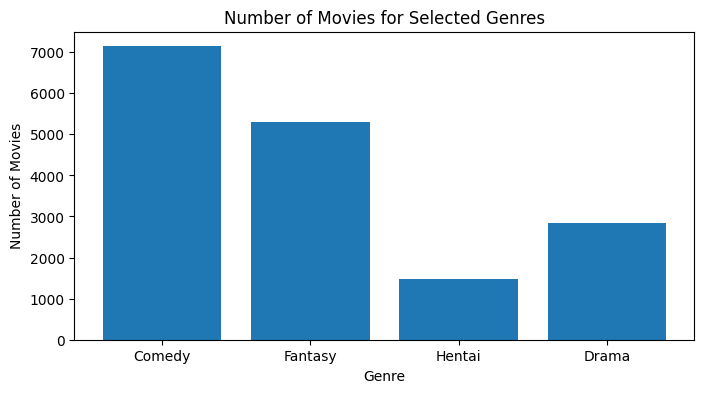

In [ ]:
selected_genres = ["Comedy", "Fantasy", "Hentai", "Drama"]

# Create a list of filtered DataFrames for each selected genre
filtered_dfs = [
    anime_df.filter(col("Genres").like("%{}%".format(genre)))
    for genre in selected_genres
]

# Create a new column with the length of the "Genres" strings for each DataFrame
length_dfs = [df.withColumn("GenresLength", length(col("Genres"))) for df in filtered_dfs]

# Get the count of movies for each genre
count_per_genre = [df.groupBy().agg(count("*").alias("Count")).collect()[0]["Count"] for df in length_dfs]

# Plot a bar chart
plt.figure(figsize=(8, 4))
plt.bar(selected_genres, count_per_genre)
plt.xlabel("Genre")
plt.ylabel("Number of Movies")
plt.title("Number of Movies for Selected Genres")
plt.show()

Most of the movies are actually Comedy, and least Hentai

### 4.1.2 Type

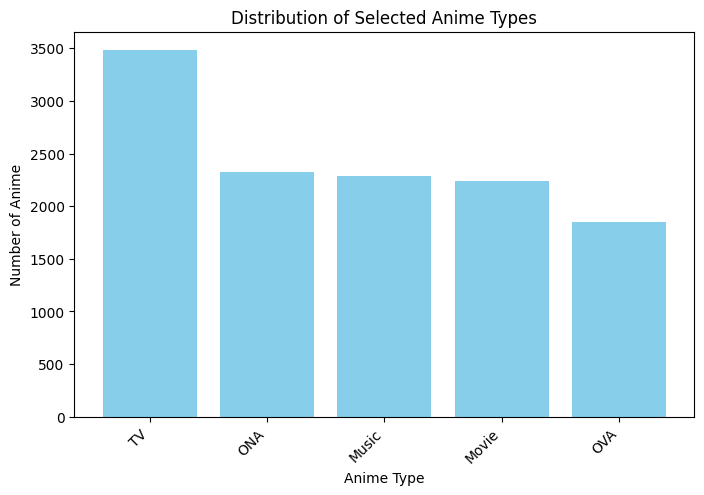

In [ ]:
selected_types = ["Movie", "OVA", "ONA", "Music", "TV"]

# Filter the anime dataset for the selected types
filtered_df = anime_df.filter(col("Type").isin(selected_types))

# Group by anime type and count the number of occurrences
anime_type_counts = filtered_df.groupBy("Type").agg(count("*").alias("Count")).sort(col("Count").desc())

# Convert to Pandas DataFrame for easier plotting
anime_type_counts_pd = anime_type_counts.toPandas()

# Plot a bar chart
plt.figure(figsize=(8, 5))
plt.bar(anime_type_counts_pd["Type"], anime_type_counts_pd["Count"], color='skyblue')
plt.xlabel("Anime Type")
plt.ylabel("Number of Anime")
plt.title("Distribution of Selected Anime Types")
plt.xticks(rotation=45, ha="right")
plt.show()

Semms the data contains the most TV

### 4.1.3 Favorites

In [ ]:
filtered_df.show()

+--------------------+--------------------+--------------------+------------------------------+--------------------+--------------------+--------------------+----+--------+--------------------+-----------+---------------+--------------------+--------------------+-----------------+------------+-------------+--------------------+------+----------+---------+---------+-------+--------------------+
|            anime_id|                Name|        English name|                    Other name|               Score|              Genres|            Synopsis|Type|Episodes|               Aired|  Premiered|         Status|           Producers|           Licensors|          Studios|      Source|     Duration|              Rating|  Rank|Popularity|Favorites|Scored By|Members|           Image URL|
+--------------------+--------------------+--------------------+------------------------------+--------------------+--------------------+--------------------+----+--------+--------------------+-----------+-

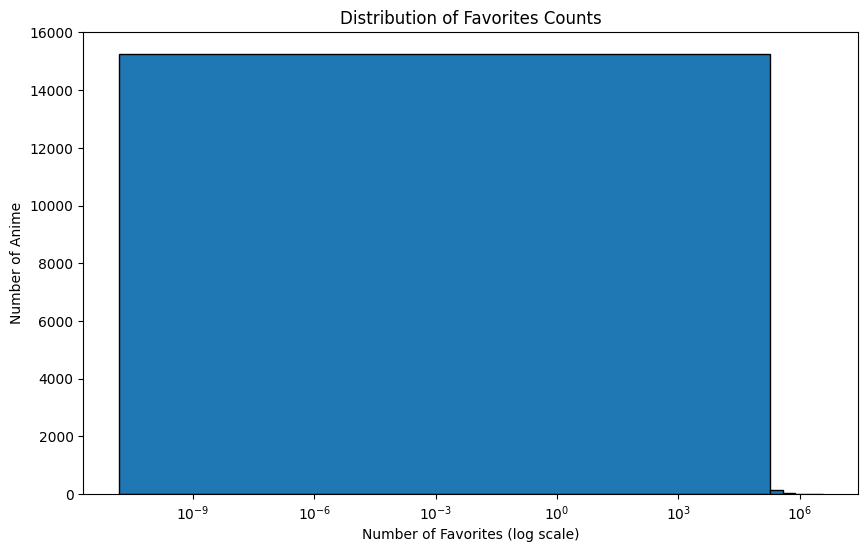

In [ ]:
filtered_df = anime_df.filter(
    col("Favorites").isNotNull() & (col("Favorites") != "") & (col("Favorites") != "Unknown")
)

# Convert the "Favorites" column to integers
filtered_df = filtered_df.withColumn("Favorites", col("Favorites").cast("int"))

# Prepare data for the histogram
favorites_counts = filtered_df.select("Favorites").rdd.flatMap(lambda x: x).filter(lambda x: x is not None).collect()

# Plot the histogram with log scale on x-axis
plt.figure(figsize=(10, 6))
plt.hist(favorites_counts, bins=20, edgecolor="black")
plt.xscale('log')  # Set log scale on x-axis
plt.xlabel("Number of Favorites (log scale)")
plt.ylabel("Number of Anime")
plt.title("Distribution of Favorites Counts")
plt.show()

## 4.2 User details

### 4.2.1 Gender Distribution

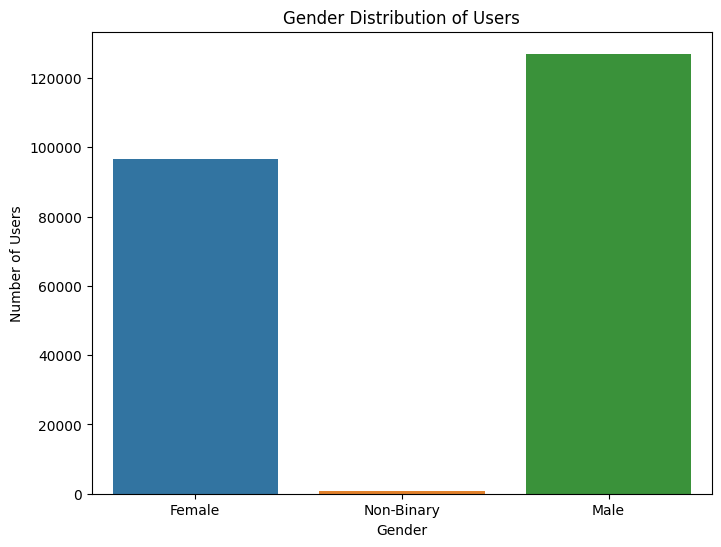

In [ ]:
gender_counts = users_details_df.groupBy("Gender").count().toPandas()
# Plot a bar chart
plt.figure(figsize=(8, 6))
sns.barplot(x="Gender", y="count", data=gender_counts)
plt.xlabel("Gender")
plt.ylabel("Number of Users")
plt.title("Gender Distribution of Users")
plt.show()


### 4.2.2 Age Distribution

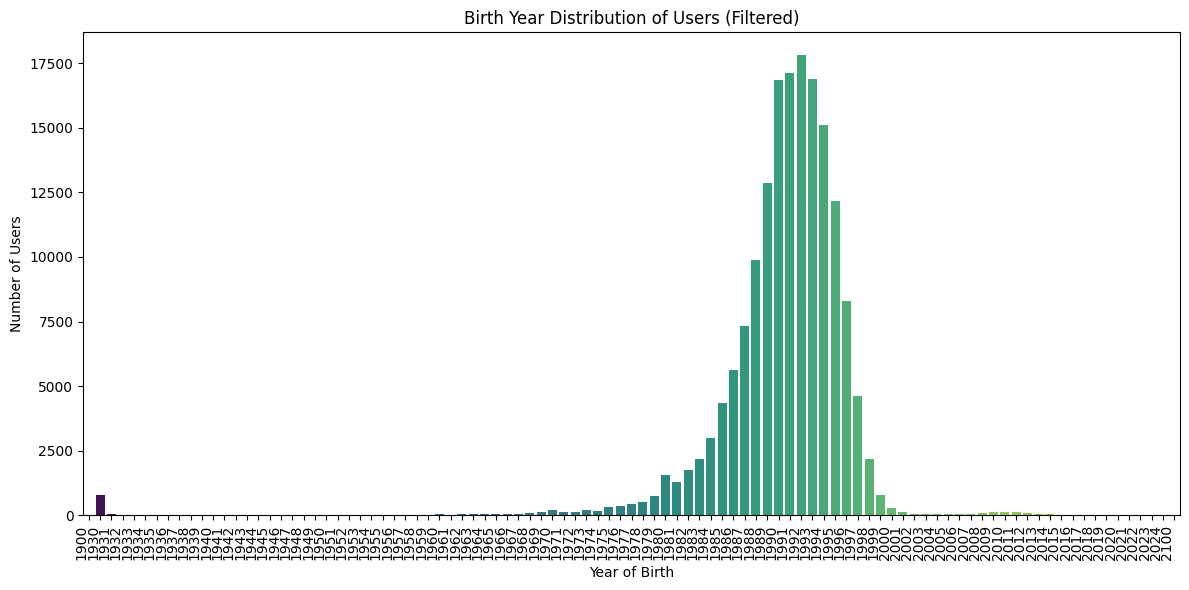

In [ ]:
users_details_df = users_details_df.withColumn("Birthday", to_date("Birthday", "yyyy-MM-dd"))
users_details_df_year_only = users_details_df.withColumn("YearOfBirth", year("Birthday")).select("YearOfBirth")
users_details_df_year_only_filtered = (
    users_details_df_year_only
    .filter(col("YearOfBirth").isNotNull())
    .filter(col("YearOfBirth") >= 1900)
)

# Convert the DataFrame to Pandas for plotting
year_counts = users_details_df_year_only_filtered.groupBy("YearOfBirth").count().toPandas()

# Plot a bar chart
plt.figure(figsize=(12, 6))
ax = sns.barplot(x="YearOfBirth", y="count", data=year_counts, palette="viridis")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")

plt.xlabel("Year of Birth")
plt.ylabel("Number of Users")
plt.title("Birth Year Distribution of Users (Filtered)")
plt.tight_layout()
plt.show()

it's gaussian distribuion mostly around 1995

### 4.2.3 Mean score

In [ ]:
from pyspark.sql.functions import col

# Define the rating intervals
rating_intervals = [(i, i + 1) for i in range(10)]

# Initialize an empty list to store the counts
num_rows_per_interval = []

# Iterate through the rating intervals and count the rows for each interval
for interval in rating_intervals:
    start, end = interval
    count = (
        users_details_df
        .filter((col("Mean Score").isNotNull()) & (col("Mean Score") >= start) & (col("Mean Score") < end))
        .count()
    )
    num_rows_per_interval.append(count)

# Print the list of counts
print("Number of rows for each Mean Score interval:", num_rows_per_interval)


Number of rows for each Mean Score interval: [376196, 435, 192, 295, 838, 4827, 30614, 118886, 121830, 52255]


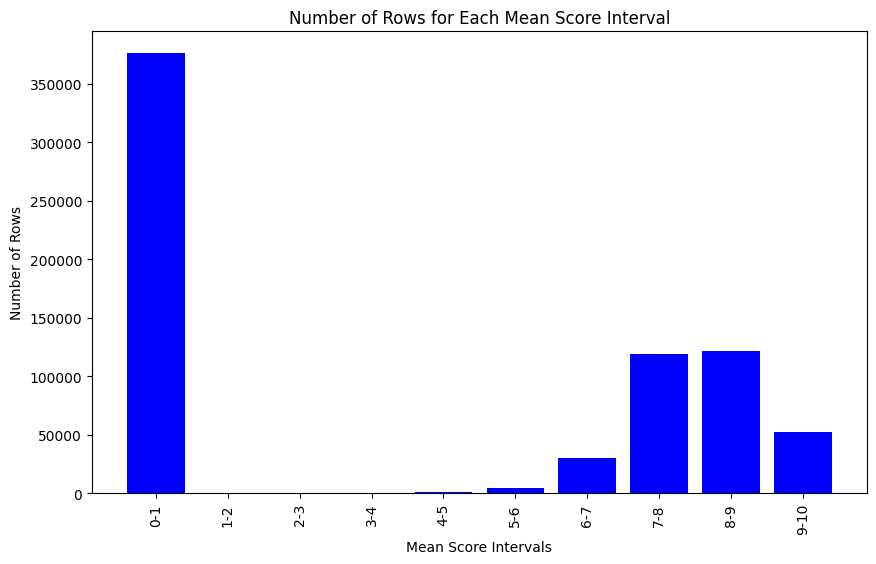

In [ ]:
# Rating intervals and counts
rating_intervals = [(i, i + 1) for i in range(10)]
# Format x-axis labels
x_labels = ["{}-{}".format(start, end) for start, end in rating_intervals]

# Plot the bar chart
plt.figure(figsize=(10, 6))
plt.bar(x_labels, num_rows_per_interval, color='blue')
plt.xlabel("Mean Score Intervals")
plt.ylabel("Number of Rows")
plt.title("Number of Rows for Each Mean Score Interval")
plt.xticks(rotation=90)  # Rotate x-axis labels for better visibility
plt.show()

most peopl rate between 0 and 1

### 4.2.4 Watching vs. Completed Anime:

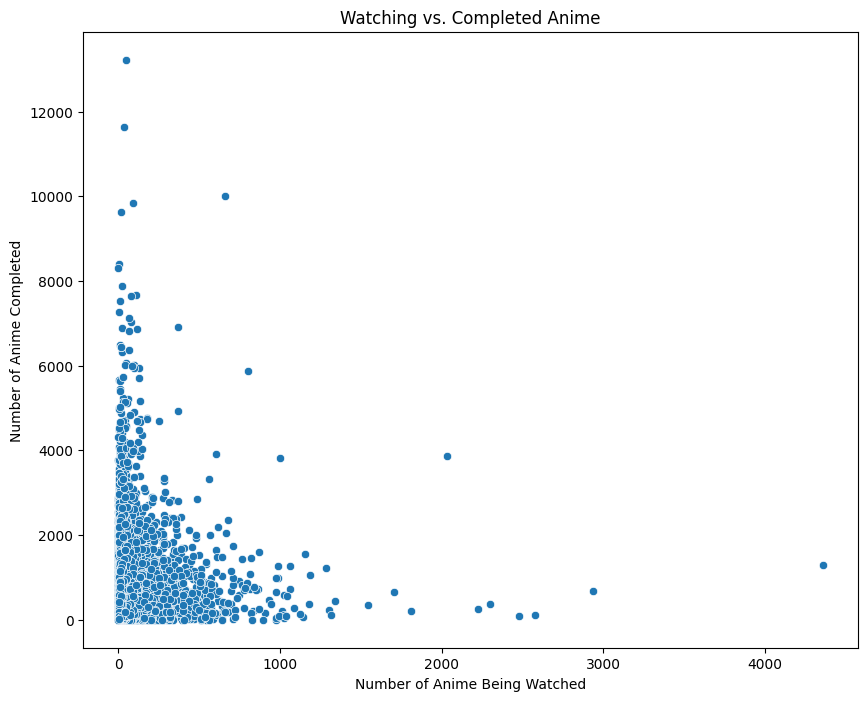

In [ ]:
# Watching vs. Completed
watching_completed_counts = users_details_df.select("Watching", "Completed").toPandas()

# Plot a scatter plot
plt.figure(figsize=(10, 8))
sns.scatterplot(x="Watching", y="Completed", data=watching_completed_counts)
plt.xlabel("Number of Anime Being Watched")
plt.ylabel("Number of Anime Completed")
plt.title("Watching vs. Completed Anime")
plt.show()


## 4.4 Joint exploration

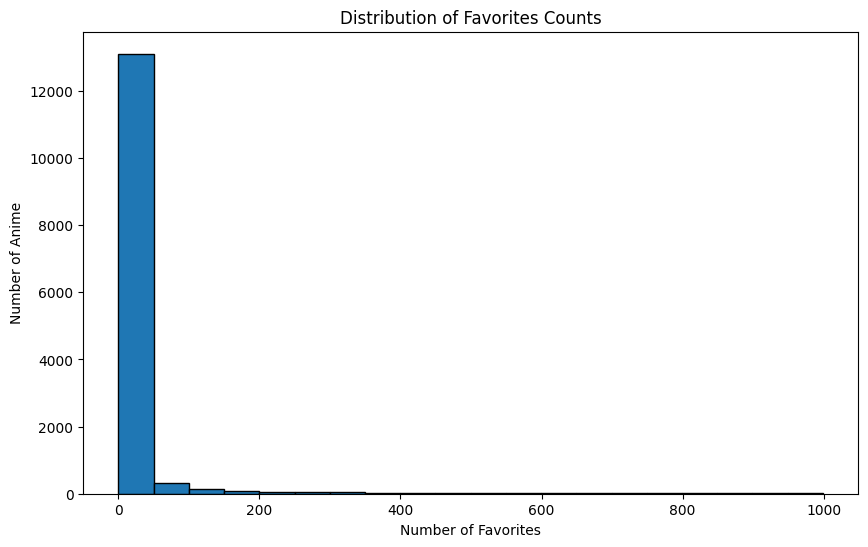

In [ ]:
filtered_df = anime_df.filter(
    col("Favorites").isNotNull() & (col("Favorites") != "") & (col("Favorites") != "Unknown")
)

# Convert the "Favorites" column to integers
filtered_df = filtered_df.withColumn("Favorites", col("Favorites").cast("int"))

# Prepare data for the histogram
favorites_counts = filtered_df.select("Favorites").rdd.flatMap(lambda x: x).filter(lambda x: x is not None and x <= 1000).collect()

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(favorites_counts, bins=20, edgecolor="black")
plt.xlabel("Number of Favorites")
plt.ylabel("Number of Anime")
plt.title("Distribution of Favorites Counts")
plt.show()

# 5.0 cleaning the data


In [ ]:
import pandas as pd
anime = pd.read_csv("/content/comp_data/anime-dataset-2023.csv")
users_details = pd.read_csv("/content/comp_data/users-details-2023.csv")
users_score = pd.read_csv("/content/comp_data/users-score-2023.csv")


##5.1 drop columns that will not be used,null and duplicate


In [ ]:
filtered_cols_users_score=users_score[['user_id','anime_id','rating']]
filtered_cols_users_score.head()

,user_id,anime_id,rating
0,1,21,9
1,1,48,7
2,1,320,5
3,1,49,8
4,1,304,8


In [ ]:
filtered_cols_users_score.dropna().drop_duplicates()

,user_id,anime_id,rating
0,1,21,9
1,1,48,7
2,1,320,5
3,1,49,8
4,1,304,8
...,...,...,...
24325186,1291087,10611,3
24325187,1291087,174,6
24325188,1291097,1535,9
24325189,1291097,226,10


##5.2 preprocessing

###5.2.1 scale rating

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

# Scale the 'score' column between 0 and 1
filtered_cols_users_score['scaled_score'] = scaler.fit_transform(filtered_cols_users_score[['rating']])

<ipython-input-23-a15cb111dc3f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_cols_users_score['scaled_score'] = scaler.fit_transform(filtered_cols_users_score[['rating']])


In [ ]:
filtered_cols_users_score.head()

,user_id,anime_id,rating,scaled_score
0,1,21,9,0.888889
1,1,48,7,0.666667
2,1,320,5,0.444444
3,1,49,8,0.777778
4,1,304,8,0.777778


###5.2.2 encode categorical

In [ ]:
from sklearn.preprocessing import LabelEncoder
user_encoder = LabelEncoder()
filtered_cols_users_score["user_encoded"] = user_encoder.fit_transform(filtered_cols_users_score["user_id"])
num_users = len(user_encoder.classes_)


anime_encoder = LabelEncoder()
filtered_cols_users_score["anime_encoded"] = anime_encoder.fit_transform(filtered_cols_users_score["anime_id"])
num_animes = len(anime_encoder.classes_)

# Printing dataset information
print("Number of unique users: {}, Number of unique anime: {}".format(num_users, num_animes))

Number of unique users: 270033, Number of unique anime: 16500


#6 the model

##6.1 shuffle the data

In [ ]:
from sklearn.utils import shuffle
filtered_cols_users_score = shuffle(filtered_cols_users_score, random_state=100)

X = filtered_cols_users_score[['user_encoded', 'anime_encoded']].values
y = filtered_cols_users_score["scaled_score"].values

print("Shape of X:", X.shape)
print("Shape of y:", y.shape)


Shape of X: (24325191, 2)
Shape of y: (24325191,)


## 6.2 spliting the data

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=100000, random_state=73)

print("Number of samples in the training set:", len(y_train))
print("Number of samples in the test set:", len(y_test))

Number of samples in the training set: 24225191
Number of samples in the test set: 100000


In [ ]:
X_train_array = [X_train[:, 0], X_train[:, 1]]
X_test_array = [X_test[:, 0], X_test[:, 1]]


##6.4 preparing the model

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Dot, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def RecommenderNet(num_users, num_animes, embedding_size=64):
    user = Input(name='user_encoded', shape=[1])
    user_embedding = Embedding(name='user_embedding', input_dim=num_users, output_dim=embedding_size)(user)

    anime = Input(name='anime_encoded', shape=[1])
    anime_embedding = Embedding(name='anime_embedding', input_dim=num_animes, output_dim=embedding_size)(anime)

    dot_product = Dot(name='dot_product', normalize=True, axes=2)([user_embedding, anime_embedding])
    flattened = Flatten()(dot_product)

    dense = Dense(64, activation='relu')(flattened)
    output = Dense(1, activation='sigmoid')(dense)

    # Create and compile the model
    model = Model(inputs=[user, anime], outputs=output)
    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=["mae", "mse"])

    return model
model = RecommenderNet(num_users, num_animes)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 user_encoded (InputLayer)   [(None, 1)]                  0         []                            
                                                                                                  
 anime_encoded (InputLayer)  [(None, 1)]                  0         []                            
                                                                                                  
 user_embedding (Embedding)  (None, 1, 64)                1728211   ['user_encoded[0][0]']        
                                                          2                                       
                                                                                                  
 anime_embedding (Embedding  (None, 1, 64)                1056000   ['anime_encoded[0][0]']   

In [ ]:
## Import necessary callbacks
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping

start_lr = 0.00001
min_lr = 0.00001
max_lr = 0.00005
batch_size = 1000000

rampup_epochs = 5
sustain_epochs = 0
exp_decay = .8

def lrfn(epoch):
    if epoch < rampup_epochs:
        return (max_lr - start_lr) / rampup_epochs * epoch + start_lr
    elif epoch < rampup_epochs + sustain_epochs:
        return max_lr
    else:
        return (max_lr - min_lr) * exp_decay**(epoch - rampup_epochs - sustain_epochs) + min_lr

lr_callback = LearningRateScheduler(lambda epoch: lrfn(epoch), verbose=0)

checkpoint_filepath = '/kaggle/working/myanimeweights.h5'
# Model checkpoint callback to save the best weights
model_checkpoints = ModelCheckpoint(filepath=checkpoint_filepath,
                                    save_weights_only=True,
                                    monitor='val_loss',
                                    mode='min',
                                    save_best_only=True)

early_stopping = EarlyStopping(patience=3, monitor='val_loss', mode='min', restore_best_weights=True)

# Define the list of callbacks
my_callbacks = [
    model_checkpoints,
    lr_callback,
    early_stopping
]

##6.5 trainng

In [ ]:
history = model.fit(
    x=X_train_array,
    y=y_train,
    batch_size=batch_size,
    epochs=10,
    verbose=1,
    validation_data=(X_test_array, y_test),
    callbacks=my_callbacks
)

model.load_weights(checkpoint_filepath)

Epoch 1/10
25/25 [==============================] - 20s 466ms/step - loss: 0.6915 - mae: 0.2620 - mse: 0.0889 - val_loss: 0.6913 - val_mae: 0.2615 - val_mse: 0.0886 - lr: 1.0000e-05
Epoch 2/10
25/25 [==============================] - 11s 435ms/step - loss: 0.6909 - mae: 0.2616 - mse: 0.0886 - val_loss: 0.6906 - val_mae: 0.2609 - val_mse: 0.0883 - lr: 1.8000e-05
Epoch 3/10
25/25 [==============================] - 11s 420ms/step - loss: 0.6901 - mae: 0.2608 - mse: 0.0882 - val_loss: 0.6896 - val_mae: 0.2600 - val_mse: 0.0878 - lr: 2.6000e-05
Epoch 4/10
25/25 [==============================] - 9s 326ms/step - loss: 0.6889 - mae: 0.2598 - mse: 0.0876 - val_loss: 0.6882 - val_mae: 0.2589 - val_mse: 0.0871 - lr: 3.4000e-05
Epoch 5/10
25/25 [==============================] - 9s 371ms/step - loss: 0.6874 - mae: 0.2585 - mse: 0.0869 - val_loss: 0.6866 - val_mae: 0.2574 - val_mse: 0.0863 - lr: 4.2000e-05
Epoch 6/10
25/25 [==============================] - 9s 371ms/step - loss: 0.6856 - mae: 0.25

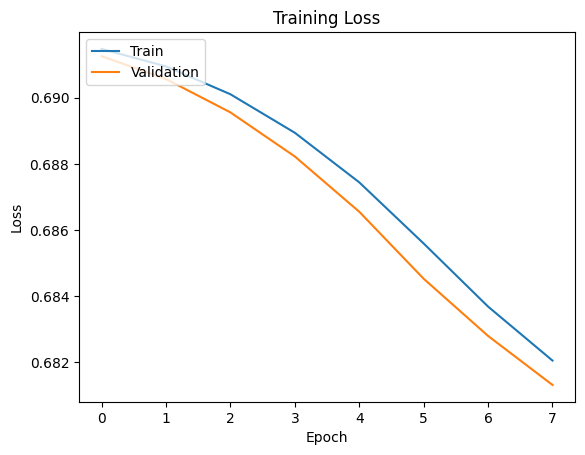

In [ ]:
plt.plot(history.history["loss"][0:-2])
plt.plot(history.history["val_loss"][0:-2])
plt.title("Training Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train", "Validation"], loc="upper left")
plt.show()

In [ ]:
results = model.evaluate(X_test_array, y_test, batch_size=128)

782/782 [==============================] - 5s 6ms/step - loss: 0.6789 - mae: 0.2506 - mse: 0.0825



#7 results

* With limited time, memory, and resources, prioritizing idea illustration is crucial.
* This straightforward model significantly enhances website recommendation systems.
* Despite data overwhelm, we opted for the simplest, most effective method to navigate time and resource constraints.
* Our results demonstrate proficient prediction of anime ratings based on users' previous ratings. This empowers us to recommend animes likely to receive high ratings from users, utilizing their preferences effectively.